# Знакомство с VLM

# Знакомимся с API transformers - 5 баллов

В данной задаче мы познакомимся с интерфейсами, которые библиотека transformers предоставляет для работы с VLM. Здесь нужно будет использовать знакомые нам функции `from_pretrained` и `apply_chat_template`, однако добавляется еще и этап препроцессинга изображений и подачи их в модель. Давайте разберемся на примере!

In [1]:
! pip install transformers==4.49.0 peft==0.14.0 datasets==3.3.2 accelerate==1.4.0

  Using cached transformers-4.49.0-py3-none-any.whl (10.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.8/374.8 kB 1.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.0.dev0
    Uninstalling transformers-4.53.0.dev0:
      Successfully uninstalled transformers-4.53.0.dev0
  Attempting uninstall: peft
    Found existing installation: peft 0.15.2
    Uninstalling peft-0.15.2:
      Successfully uninstalled peft-0.15.2

[notice] A new release of pip is available: 23.1.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import torch
from transformers import AutoModelForVision2Seq, AutoProcessor
import os


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps")#else torch.device("cpu")
model_name = "HuggingFaceTB/SmolVLM-256M-Instruct"

# не забудьте загрузить модель в fp16
model = AutoModelForVision2Seq.from_pretrained(pretrained_model_name_or_path=model_name, torch_dtype=torch.half).to(device)
processor = AutoProcessor.from_pretrained(pretrained_model_name_or_path=model_name)

In [2]:
import matplotlib.pyplot as plt

<|im_start|>User:<image>Can you describe this image?<end_of_utterance>
Assistant:


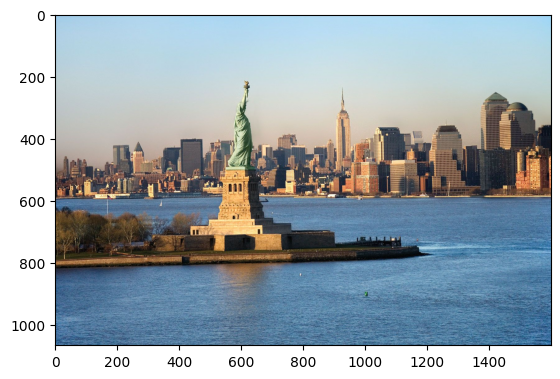

In [3]:
from transformers.image_utils import load_image

image = load_image("https://cdn.britannica.com/61/93061-050-99147DCE/Statue-of-Liberty-Island-New-York-Bay.jpg")
plt.imshow(image)

messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "Can you describe this image?"}
        ]
    },
]

# Prepare inputs
prompt = processor.apply_chat_template(conversation=messages, add_generation_prompt=True)
assert prompt == """<|im_start|>User:<image>Can you describe this image?<end_of_utterance>
Assistant:"""
print(prompt)

Как вы видите, добавляется спецтокен `<image>`, который обозначает, где картинка будет во время инференса относительно текста

In [6]:
inputs = processor(text=prompt, images=[image], return_tensors="pt")
print(inputs.keys())
print(inputs.input_ids)

dict_keys(['pixel_values', 'pixel_attention_mask', 'input_ids', 'attention_mask'])
tensor([[    1, 11126,    42, 49189, 49153, 49190, 49190, 49190, 49190, 49190,
         49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190,
         49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190,
         49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190,
         49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190,
         49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190,
         49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190, 49189,
         49154, 49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190,
         49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190,
         49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190,
         49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190, 49190,
         49190, 49190, 49190, 49190, 49190, 4919

В inputs у нас добавляется поле pixel_values - это значения картинки перед входом в ViT (visual transformer), который потом отдаст токены для подстановки в LLM.

Также вы можете видеть, что у нас очень часто встречается токен 49190, которого не было в промпте. Это токен placeholder, на позиции которого будут вставать картиночные эмбеддинги из ViT.

Давайте теперь запустим на этом жадную генерацию 32 токенов (вспомним опции do_sample и max_new_tokens)

In [7]:
inputs = inputs.to(device)

outputs = model.generate(**inputs, do_sample=False, max_new_tokens=32)
output_text =  processor.decode(outputs[0][inputs.input_ids.shape[1]:])
assert output_text == " The image depicts a large, historic statue of Liberty situated on a small island in a body of water. The statue is a green, cylindrical structure with a human"



/Users/igorchebuniaev/Library/Caches/pypoetry/virtualenvs/synthetic-multinode-6dIUQGRd-py3.10/lib/python3.10/site-packages/transformers/pytorch_utils.py:338: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_elements = torch.tensor(test_elements)


# Multi-Image - 5 баллов

Некоторые модели поддерживают сценарии с несколькими картинками - несколько картинок может быть как в одной фразе, так и в нескольких. Давайте рассмотрим вариант, где мы подаем 2 картинки за раз в один промпт

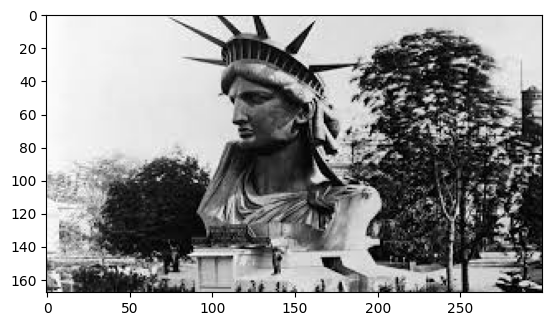

In [9]:
image2 = load_image("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTS7w8mlBMZEZAz1ejXqidkvffroe-CSNUgvg&s")
plt.imshow(image2)


In [10]:
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "image"},
            {"type": "text", "text": "What are the differences between the two images?"}
        ]
    },
]

# Prepare inputs
prompt = processor.apply_chat_template(conversation=messages)
inputs = processor(text=prompt, images=[image, image2], return_tensors="pt")
inputs = inputs.to(device)

outputs = model.generate(**inputs, do_sample=False, max_new_tokens=64)
output_text = processor.decode(outputs[0][inputs.input_ids.shape[1]:])
print(output_text)




1. The first image shows a statue of Liberty while the second image shows a statue of liberty with people around it.<end_of_utterance>


Аналогично можно продолжить историю диалога

In [11]:
image3 = load_image("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTay0Qt_Le200R2RcGaVToPsB67ypZ_3Noy5A&s")
messages = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "image"},
            {"type": "text", "text": "What are the differences between the two images?"}
        ]
    },
    {
        "role": "assistant",
        "content": [{"type": "text", "text": "they are both statues"}]
    },
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "thank you for the answer! can you tell me what objects were on the first image?"},
        ]
    },

]
prompt = processor.apply_chat_template(conversation=messages)
inputs = processor(text=prompt, images=[image, image2, image3], return_tensors="pt")
inputs = inputs.to(device)

outputs = model.generate(**inputs, do_sample=False, max_new_tokens=64)
output_text = processor.decode(outputs[0][inputs.input_ids.shape[1]:])
print(output_text)

# ответ немного путает объекты на картинках, но это 260М модель, так что
# для такого размера очень хорошо!



Answer: There is a statue of the Statue of Liberty and a hot dog on the first image.<end_of_utterance>


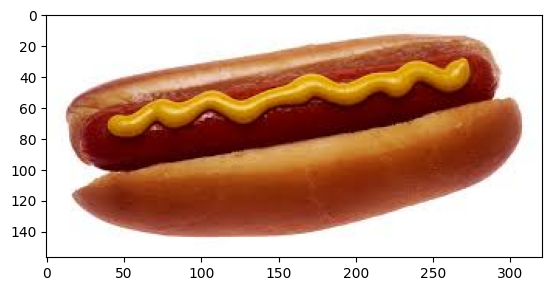

In [12]:
plt.imshow(image3)

In [13]:
print(inputs.input_ids.shape)

torch.Size([1, 2366])


Как мы видим из-за 3х картинок размер входа вырос уже до 2000 токенов!

# VLM батчи - 5
Как и в случае с VLM при использовании GPU выгоднее обрабатывать данные батчами.
Обработка данных у каждой модели VLM своя, устоявшегося API как у текстовых моделей нет. Посмотреть примеры работы можно в карточке модели.
Пример для smollm - https://huggingface.co/HuggingFaceTB/SmolVLM-256M-Instruct

Для qwen2.5vl логика другая - https://huggingface.co/Qwen/Qwen2.5-VL-72B-Instruct. Как можно увидеть, там используется вспомогательная функция `process_vision_info` для обработки картинок

У моделей нет одинакового API и не все они загружаются через AutoModelForVision..., так что будьте внимательны!

Аналогично работает и сборка изображений в батч, мы разберем ее на примере smollm:
1. В processor нужно подать список промптов (не забудьте add_generation_prompt!)
2. В качестве images нужно подать плоский список картинок

In [14]:
messages1 = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "what is on the image"}
        ]
    },
]

messages2 = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "what is on the image"}
        ]
    },
]


batch_of_messages = [messages1, messages2]
batch_of_images = [image2, image3]
prompts = processor.apply_chat_template(batch_of_messages, add_generation_prompt=True)
inputs = processor(text=prompts, images=batch_of_images, return_tensors="pt", padding=True)
inputs = inputs.to(device)

outputs = model.generate(**inputs, do_sample=False, max_new_tokens=64)

# output_text1 = processor.decode(...)
# output_text2 = processor.decode(...)

# print(output_text1)
# print(output_text2)



TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.

In [66]:
prompts

['<|im_start|>User:<image>what is on the image<end_of_utterance>\nAssistant:',
 '<|im_start|>User:<image>what is on the image<end_of_utterance>\nAssistant:']

Как видно из примера - здесь можно подать просто список картинок и он будет раскидан между примерами в батче. В llama3.2 vision нужно подавать список списков каринок, где каждый внутренний список принадлежит конкретному сэмплу из батча. Всегда проверяйте эту логику, логика батчевания зачастую опущена в карточке модели!

# VLM benchmark - 10 баллов
Давайте теперь попробуем сделать замеры нашей модели на бенчмарке mmmu! Вспомним доступные LLM, только в этот раз вам предоставлено больше свободы - можно использовать генерацию ответа вместо скоринга.

In [ ]:
from datasets import load_dataset
dataset = load_dataset("MMMU/MMMU", "Literature")

In [ ]:
dataset["validation"][0]

В датасете есть вопрос question, картинка или картинки (image_1..7), варианты ответа options и правильный ответ answer.
Ваша задача прогнать модель на этом датасете, собрать ответы и проверить точность. Можно использовать батчевание, а можно прогонять по одному сэмплу на ваше усмотрение!
В качестве метрики можно репортить accuracy.

In [ ]:
...


# Обучение VLM - 25 баллов
Давайте попробуем обучить pretrain-VLM на какой-нибудь простой задаче. Это не instruct модель, так что она не способна отвечать на произвольный вопрос по картинке

In [ ]:
import os
import torch
from datasets import load_dataset
from transformers import AutoModelForVision2Seq, AutoProcessor

from peft import LoraConfig, get_peft_model
from transformers.image_utils import load_image

device = torch.device("cuda")
model_name = "HuggingFaceTB/SmolVLM-Base"
model = AutoModelForVision2Seq.from_pretrained(model_name, torch_dtype=torch.bfloat16).eval().to(device)
processor = AutoProcessor.from_pretrained(model_name)

Эта модель обучена просто на документах с картинками, поэтому она будет игнорировать вопросы и продолжать текст как из статей

In [ ]:
messages1 = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "the image depicts"}
        ]
    },
]

messages2 = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "how many objects are on the image?"}
        ]
    },
]

image = load_image("https://cdn.britannica.com/61/93061-050-99147DCE/Statue-of-Liberty-Island-New-York-Bay.jpg")

image3 = load_image("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTay0Qt_Le200R2RcGaVToPsB67ypZ_3Noy5A&s")

batch_of_messages = ...
batch_of_images = ...
prompts = [...]
inputs = processor(...)
inputs = inputs.to(device)

outputs = model.generate(...)

output_text1 = processor.decode(...)
output_text2 = processor.decode(...)

print(output_text1)
print(output_text2)




Загрузим датасет vqav2-small - visual question answering, попробуем обучить на нем нашу модель в SFT

In [ ]:
dataset = load_dataset('merve/vqav2-small', trust_remote_code=True)
split_ds = dataset["validation"].train_test_split(test_size=0.5, seed=5)
train_ds = split_ds["train"]

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(train_ds[0]["image"])
print("Question:", train_ds[0]["question"])
print("Answer:", train_ds[0]["multiple_choice_answer"])

Собираем Lora-модель, в качестве ранга, чтобы все влезло в colab рекомендую взять ранг 4

In [ ]:
lora_rank = ...
lora_config = LoraConfig(
    r=...,
    lora_alpha=...,
    lora_dropout=0.1,
    target_modules=['down_proj','o_proj','k_proj','q_proj','gate_proj','up_proj','v_proj'],
)
model.add_adapter(lora_config)
model.enable_adapters()

model = get_peft_model(model, lora_config)
if lora_rank == 4:
  assert model.get_nb_trainable_parameters()[0] == 5268480


Функция transform_example_to_prompt должна делать следующее:
1. Брать пример из датасета, собирать его в messages вида \[Юзер: картинка + вопрос, Ассистент: ответ]
2. Превращать эти messages в полный промпт, который содержит вопрос, картинку и ответ
3. Брать только первое сообщение из messages и превращать его в промпт без ответа (но с generation_prompt!). Будем называть его prefix_prompt
4. Считать длину prefix_prompt в токенах с учетом подстановки изображения. Это понадобится нам для маскирования префикса, т.к. функцию потерь мы хотим считать только по ответу
5. Возвращаем: полный промпт (строку), картинку и длину префикса

In [ ]:
from typing import Tuple
def transform_example_to_prompt(example) -> Tuple[str, "Image", int]:
    """
    example
    {'multiple_choice_answer': 'cell phone',
    'question': 'What is to the right of the bananas?',
    'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x427 at 0x7EFEC8FBE6C0>
    }
    """
    ...

full_prompt, image, prefix_len = transform_example_to_prompt(train_ds[0])
assert full_prompt == "<|im_start|>User:<image>What is to the right of the bananas?<|endoftext|>\nAssistant: cell phone<|endoftext|>\n"
assert prefix_len == 1200

collate_fn - функция сборки батча (она очень похожа на то, как мы собирали батчи для инференса)
1. Проходимся по всем примерам, к каждому примеру применяем transform_example_to_prompt, запоминаем полученные значения в массивы prompts_batch, images_batch, prefix_lengths
2. Собираем входы, применяем processor к prompts_batch и images_batch
3. Начинаем заполнять labels. В labels значение -100 должно стоять на позициях, соответствующих: паддингам (processor.tokenizer.pad_token_id), картиночным токенам (model.image_token_id), а также всем токенам префикса (токенам от 0 до prefix_lengths[i])

In [ ]:
from typing import List, Dict
def collate_fn(examples: List[Dict]):
    ...



batch = collate_fn([train_ds[0], train_ds[1]])
labels = batch["labels"]

tokens_to_predict_0 = processor.tokenizer.decode(labels[0][labels[0] != -100].tolist())
tokens_to_predict_1 = processor.tokenizer.decode(labels[1][labels[1] != -100].tolist())

assert tokens_to_predict_0 == " cell phone<|endoftext|>\n"
assert tokens_to_predict_1 == " sweats<|endoftext|>\n"

Запускаем обучение, не забудьте передать:
* learning_rate (лучше 1e-4)
* эпохи обучения (я брал 1)
* gradient_checkpointing
* gradient_accumulation (4, тогда датасет на 100 сэмплов обучение будет идти 25 шагов и нам этого хватит, чтобы увидеть первые результаты)

В сетапе на коллабе я рекомендую взять датасет из 100 сэмплов.
Обучение начнется с лоссов 5.2-5.6 и постепенно будет падать (иногда могут быть скачки вверх от батча к батчу, не пугайтесь). На колабе обучение занимает около 35 минут, на H100 около 14 секунд.

Референсные лоссы для этого сетапа:
```
Step Training Loss
1 5.280100
2 5.615200
3 4.710200
4 5.496900
5 5.958500
6 6.190700
7 4.340700
8 3.609100
9 4.489100
10 4.231200
11 4.689200
12 3.090200
13 3.324200
14 3.528100
15 3.771900
16 3.551000
17 3.027500
18 3.236000
19 3.044200
20 3.597200
21 3.398800
22 3.663900
23 2.797600
24 3.266600
25 3.030400
```

In [ ]:
from transformers import TrainingArguments, Trainer


training_args = TrainingArguments(
    num_train_epochs=...,
    per_device_train_batch_size=...,
    gradient_accumulation_steps=...,
    learning_rate=...,
    weight_decay=0.01,
    logging_steps=1,
    save_strategy="steps",
    save_steps=25,
    save_total_limit=1,
    optim="adamw_hf",
    bf16=True,
    output_dir=f"./{model_name}-vqav2",
    report_to="none",
    remove_unused_columns=False,
    gradient_checkpointing=...
)

trainer = Trainer(
    ...
    train_dataset=[train_ds[i] for i in range(100)],
)

trainer.train()

Сохраним lora в модель и сохраним модель локально, чтобы ее снова загрузить (без этого на текущей ревизии у меня все падало)

In [ ]:
model.merge_and_unload()
model.save_pretrained("llocal")

In [ ]:
model = AutoModelForVision2Seq.from_pretrained("llocal", torch_dtype=torch.bfloat16).eval().to(device)


Теперь давайте убедимся, что ответы на вопросы стали разумными

In [ ]:
messages1 = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "Which country has this?"}
        ]
    },
]

messages2 = [
    {
        "role": "user",
        "content": [
            {"type": "image"},
            {"type": "text", "text": "is this food?"}
        ]
    },
]

image = load_image("https://cdn.britannica.com/61/93061-050-99147DCE/Statue-of-Liberty-Island-New-York-Bay.jpg")

image3 = load_image("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTay0Qt_Le200R2RcGaVToPsB67ypZ_3Noy5A&s")


batch_of_messages = ...
batch_of_images = ...
prompts = [...]
inputs = processor(...)
inputs = inputs.to(device)

outputs = model.generate(...)

output_text1 = processor.decode(...)
output_text2 = processor.decode(...)

print(output_text1)
print(output_text2)


